In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import pandas as pd
from planet_cookbook import read_reports as rr
import os
import rebound
import seaborn as sns

sol_to_earth = 332946.078
G = 6.6743* 10**(-11) #N⋅m2/kg2
M_sun = 1.989e+33 #g
AU = 1.496e+13 #cm

In [3]:
params = {
   'axes.labelsize': 15,
   'font.size': 15,
   'legend.fontsize': 10,
   'xtick.labelsize': 15,
   'ytick.labelsize': 15,
   'text.usetex': True, #to use TeX in your labels
   'font.family':'serif',
   'axes.titlesize': 15
   }
rcParams.update(params)

In [4]:
#Color-blind friendly pallete
colors = [
    "#0C7BDC",  # Vibrant Blue
    "#E66100",  # Bright Orange
    "#40B0A6",  # Teal/Aqua
    "#8B8D8B",  # Medium Grey
    "#5D3A9B"   # Muted Purple
]

vib_blue = "#0C7BDC"
teal = "#40B0A6"
purple = "#5D3A9B" 

In [5]:
solar_system_df = pd.read_csv('solarsystem.csv')
mercury = solar_system_df[solar_system_df['name'] == 'Mercury']
venus = solar_system_df[solar_system_df['name'] == 'Venus']
earth = solar_system_df[solar_system_df['name'] == 'Earth']
mars = solar_system_df[solar_system_df['name'] == 'Mars']

# 1) Read runtime data to see which simulations we need to keep

In [6]:
base_path = "/Users/honeyeah/Codes/data/" #folder with all data

sim_set = "ueda_v3/" #name of simulation set, folder with subfolders the name "sim_set_i"
sim_archive_path = base_path + sim_set + "ueda_v3_" #path given to get_runtime_data function
ueda_v3_rdf = rr.get_runtime_data(sim_archive_path, 60, "ueda_v3_") #rdf is runtime data frame

sim_set = "cham_bench/" #name of simulation set, folder with subfolders the name "sim_set_i"
sim_archive_path = base_path + sim_set + "cham_bench_" #path given to get_runtime_data function
cham_bench_rdf = rr.get_runtime_data(sim_archive_path, 60, "cham_simarchive_") #rdf is runtime data frame

sim_set = "cham_cont/" #name of simulation set, folder with subfolders the name "sim_set_i"
sim_archive_path = base_path + sim_set + "cham_cont_" #path given to get_runtime_data function
cham_cont_rdf = rr.get_runtime_data(sim_archive_path, 60, "cham_cont_") #rdf is runtime data frame

cut_time = 299.9e6

/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:103: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed. Binary file was saved with REBOUND Version 4.4.7. You are currently using REBOUND Version 4.4.8.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:103: Run

In [7]:
n_runs = 60

maxtimes_ueda_v3 = np.array([
    ueda_v3_rdf[ueda_v3_rdf['simulation_id'] == i + 1]['time'].max()
    for i in range(n_runs)
])

maxtimes_cham_bench = np.array([
    cham_bench_rdf[cham_bench_rdf['simulation_id'] == i + 1]['time'].max()
    for i in range(n_runs)
])

maxtimes_cham_cont = np.array([
    cham_cont_rdf[cham_cont_rdf['simulation_id'] == i + 1]['time'].max()
    for i in range(n_runs)
])

keep_ueda_v3 = np.where(maxtimes_ueda_v3 > 299.9e6)[0]
keep_cham_bench = np.where(maxtimes_cham_bench > 299.9e6)[0]
keep_cham_cont = np.where(maxtimes_cham_cont > 299.9e6)[0]

print("number of finished runs\n")
print(f"ueda_v3: {len(keep_ueda_v3)}")
print(f"cham_bench: {len(keep_cham_bench)}")
print(f"cham_cont: {len(keep_cham_cont)}")

number of finished runs

ueda_v3: 52
cham_bench: 39
cham_cont: 25


In [8]:
keep_ueda_v3 = keep_ueda_v3[keep_ueda_v3!=0]

# Read particle parameters from REBOUND SimulationArchives
# Read planet compositions from COREGIVER outputs

In [9]:
#FOR UEDA V3

ueda_v3_ppdf_list = rr.get_particle_params_at_time(
    f"/Users/honeyeah/Codes/data/ueda_v3/ueda_v3_", keep_ueda_v3, "ueda_v3_", cut_time
)

ueda_v3_pldf_33_list = []
for j, i in enumerate(keep_ueda_v3):
    df = rr.read_dbct_output(
        f"/Users/honeyeah/Codes/data/ueda_v3/ueda_v3_{i+1}/uniform_33.txt",
        0.3, "none", "none"
    )

    df_len = len(df)
    param_len = len(ueda_v3_ppdf_list[j])

    min_len = min(df_len, param_len)

    if min_len == 0:
        print(f"Skipping index {i}: empty df or param list.")
        continue

    # Trim both to same length
    df = df.iloc[:min_len].copy()
    semi_values = ueda_v3_ppdf_list[j]['semi'][:min_len]
    df['semi'] = semi_values.values  # if semi_values is a Series
    df['sim_id'] = i + 1

    ueda_v3_pldf_33_list.append(df)


ueda_v3_pldf_40_list = []
for j, i in enumerate(keep_ueda_v3):
    df = rr.read_dbct_output(
        f"/Users/honeyeah/Codes/data/ueda_v3/ueda_v3_{i+1}/uniform_40.txt",
        0.4, "none", "none"
    )

    df_len = len(df)
    param_len = len(ueda_v3_ppdf_list[j])

    min_len = min(df_len, param_len)

    if min_len == 0:
        print(f"Skipping index {i}: empty df or param list.")
        continue

    # Trim both to same length
    df = df.iloc[:min_len].copy()
    semi_values = ueda_v3_ppdf_list[j]['semi'][:min_len]
    df['semi'] = semi_values.values  # if semi_values is a Series
    df['sim_id'] = i + 1

    ueda_v3_pldf_40_list.append(df)


/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:103: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed. Binary file was saved with REBOUND Version 4.4.7. You are currently using REBOUND Version 4.4.8.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:103: Run

In [10]:
cham_bench_ppdf_list = rr.get_particle_params_at_time(
    f"/Users/honeyeah/Codes/data/cham_bench/cham_bench_", keep_cham_bench, "cham_simarchive_", cut_time
)

cham_bench_pldf_33_list = []

for j, i in enumerate(keep_cham_bench):
    df = rr.read_dbct_output(
        f"/Users/honeyeah/Codes/data/cham_bench/cham_bench_{i+1}/uniform_33.txt",
        0.3, "none", "none"
    )

    df_len = len(df)
    param_len = len(cham_bench_ppdf_list[j])

    min_len = min(df_len, param_len)

    if min_len == 0:
        print(f"Skipping index {i}: empty df or param list.")
        continue

    # Trim both to same length
    df = df.iloc[:min_len].copy()
    semi_values = cham_bench_ppdf_list[j]['semi'][:min_len]
    df['semi'] = semi_values.values  # if semi_values is a Series
    df['sim_id'] = i + 1

    cham_bench_pldf_33_list.append(df)

cham_bench_pldf_40_list = []

for j, i in enumerate(keep_cham_bench):
    df = rr.read_dbct_output(
        f"/Users/honeyeah/Codes/data/cham_bench/cham_bench_{i+1}/uniform_40.txt",
        0.4, "none", "none"
    )

    df_len = len(df)
    param_len = len(cham_bench_ppdf_list[j])

    min_len = min(df_len, param_len)

    if min_len == 0:
        print(f"Skipping index {i}: empty df or param list.")
        continue

    # Trim both to same length
    df = df.iloc[:min_len].copy()
    semi_values = cham_bench_ppdf_list[j]['semi'][:min_len]
    df['semi'] = semi_values.values  # if semi_values is a Series
    df['sim_id'] = i + 1

    cham_bench_pldf_40_list.append(df)


/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:103: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed. Binary file was saved with REBOUND Version 4.4.7. You are currently using REBOUND Version 4.4.8.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:103: Run

In [11]:
cham_cont_ppdf_list = rr.get_particle_params_at_time(
    f"/Users/honeyeah/Codes/data/cham_cont/cham_cont_", keep_cham_cont, "cham_cont_", cut_time
)

cham_cont_pldf_33_list = []

for j, i in enumerate(keep_cham_cont):
    df = rr.read_dbct_output(
        f"/Users/honeyeah/Codes/data/cham_cont/cham_cont_{i+1}/uniform_33.txt",
        0.3, "none", "none"
    )

    df_len = len(df)
    param_len = len(cham_cont_ppdf_list[j])

    min_len = min(df_len, param_len)

    if min_len == 0:
        print(f"Skipping index {i}: empty df or param list.")
        continue

    # Trim both to same length
    df = df.iloc[:min_len].copy()
    semi_values = cham_cont_ppdf_list[j]['semi'][:min_len]
    df['semi'] = semi_values.values  # if semi_values is a Series
    df['sim_id'] = i + 1

    cham_cont_pldf_33_list.append(df)


cham_cont_pldf_40_list = []

for j, i in enumerate(keep_cham_cont):
    df = rr.read_dbct_output(
        f"/Users/honeyeah/Codes/data/cham_cont/cham_cont_{i+1}/uniform_40.txt",
        0.3, "none", "none"
    )

    df_len = len(df)
    param_len = len(cham_cont_ppdf_list[j])

    min_len = min(df_len, param_len)

    if min_len == 0:
        print(f"Skipping index {i}: empty df or param list.")
        continue

    # Trim both to same length
    df = df.iloc[:min_len].copy()
    semi_values = cham_cont_ppdf_list[j]['semi'][:min_len]
    df['semi'] = semi_values.values  # if semi_values is a Series
    df['sim_id'] = i + 1

    cham_cont_pldf_40_list.append(df)


/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:103: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed. Binary file was saved with REBOUND Version 4.4.7. You are currently using REBOUND Version 4.4.8.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:103: Run

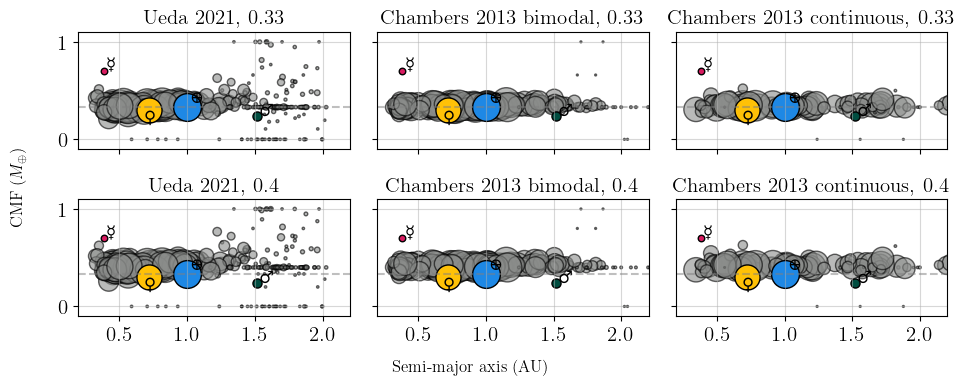

time = 3.00e+08 yrs


In [12]:
ueda_v3_pldf_33 = pd.concat(ueda_v3_pldf_33_list)
cham_bench_pldf_33 = pd.concat(cham_bench_pldf_33_list)
cham_cont_pldf_33 = pd.concat(cham_cont_pldf_33_list)

ueda_v3_pldf_40 = pd.concat(ueda_v3_pldf_40_list)
cham_bench_pldf_40 = pd.concat(cham_bench_pldf_40_list)
cham_cont_pldf_40 = pd.concat(cham_cont_pldf_40_list)

fig, axes = plt.subplots(2, 3, figsize=(10, 4), sharey=True, sharex=True)

# Plot configs
datasets = [
    ("Ueda 2021, 0.33", ueda_v3_pldf_33, colors[3]),
    ("Chambers 2013 bimodal, 0.33", cham_bench_pldf_33, colors[3]),
    ("Chambers 2013 continuous, 0.33", cham_cont_pldf_33, colors[3]),
    ("Ueda 2021, 0.4", ueda_v3_pldf_40, colors[3]),
    ("Chambers 2013 bimodal, 0.4", cham_bench_pldf_40, colors[3]),
    ("Chambers 2013 continuous, 0.4", cham_cont_pldf_40, colors[3])
]

dot_scale = 400

for ax, (label, df, color) in zip(axes.flat, datasets):
    ax.grid(True, alpha = 0.5)
    ax.plot([0.2, 2.2], [0.33, 0.33], linestyle='dashed', color='grey', alpha=0.5)

    ax.scatter(df['semi'], df['cmf'], alpha=0.6, color=color,
               edgecolors='black', linewidths=1, s = df['mass'] * sol_to_earth * dot_scale)

    # Add Mercury & Earth
    ax.scatter(0.387, 0.7, color='#D81B60', edgecolors='black', linewidths=1, s= 0.055 * dot_scale, label = 'Mercury')
    ax.annotate('☿', [0.4, 0.71], fontsize=12, usetex=False)

    ax.scatter(0.723, 0.3, color='#FFC107', edgecolors='black', linewidths=1, s=0.815 * dot_scale, label = 'Venus')
    ax.annotate('♀', [0.68, 0.18], fontsize=12, usetex=False)

    ax.scatter(1, 0.33, color='#1E88E5', edgecolors='black', linewidths=1, s=dot_scale, label = 'Earth')
    ax.annotate('⊕', [1.02, 0.38], fontsize=12, usetex=False)

    ax.scatter(1.52, 0.24, color='#004D40', edgecolors='black', linewidths=1, s=0.107 * dot_scale, label = 'Mars')
    ax.annotate('♂', [1.53, 0.25], fontsize=12, usetex=False)

   
    # Reference lines
    #ax.plot([0.35, 2], [0.3, 0.3], linestyle='dashed', color='grey', alpha=0.5)
    #ax.plot([0.35, 0.35], [0.01, 1.2], linestyle='dashed', color='grey', alpha=0.5)
    #ax.plot([0.7, 0.7], [0.01, 1.2], linestyle='dashed', color='grey', alpha=0.5)

    ax.set_xlim(0.2, 2.2)
    ax.set_ylim(-0.1,1.1)
    ax.set_title(label)

#ax.legend(loc = 'upper right')

# Shared axis labels
fig.text(0.5, 0.04, 'Semi-major axis (AU)', ha='center', fontsize=12)
fig.text(0.04, 0.5, r'CMF ($M_\oplus$)', va='center', rotation='vertical', fontsize=12)

#fig.suptitle('Uniform CMF distributions (0.33)')
plt.tight_layout(rect=[0.05, 0.05, 1, 1])

plt.savefig("paper_plots/uniform_cmf_dists.pdf", dpi=300)  # or .png

plt.show()

print(f"time = {cut_time:.2e} yrs")
#print("mean max time reached for Ueda v1 = ", np.average(maxtimes_ueda_v1)/1e6, "Myrs")
#print("mean max time reached for Cham = ", np.average(maxtimes_cham_bench)/1e6, "Myrs")

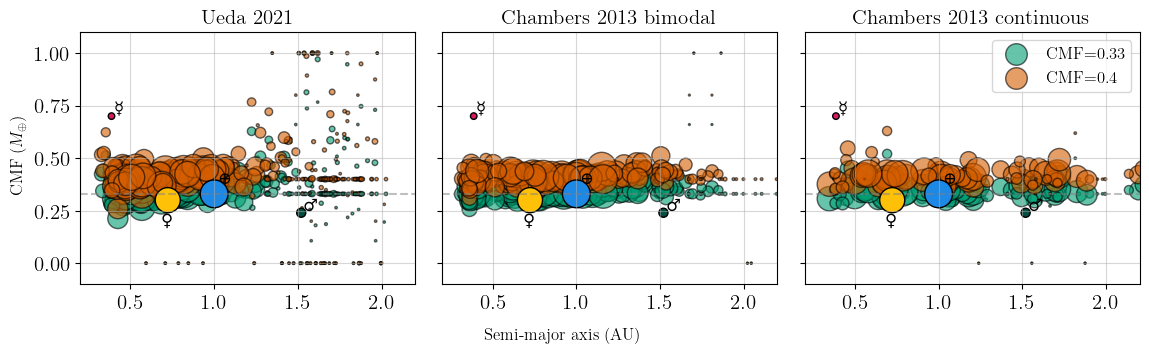

time = 3.00e+08 yrs


In [13]:
# Colorblind-friendly palette (CUD: https://jfly.uni-koeln.de/color/)
color_033 = "#009E73"  # blue
color_040 = "#D55E00"  # vermillion

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True, sharex=True)

datasets = [
    ("Ueda 2021", ueda_v3_pldf_33, ueda_v3_pldf_40),
    ("Chambers 2013 bimodal", cham_bench_pldf_33, cham_bench_pldf_40),
    ("Chambers 2013 continuous", cham_cont_pldf_33, cham_cont_pldf_40)
]

dot_scale = 400
ind = 0

for ax, (label, df_033, df_040) in zip(axes, datasets):
    ax.grid(True, alpha=0.5)
    ax.plot([0.2, 2.2], [0.33, 0.33], linestyle='dashed', color='grey', alpha=0.5)

    # 0.33 points
    ax.scatter(df_033['semi'], df_033['cmf'], alpha=0.6, color=color_033,
               edgecolors='black', linewidths=1, s=df_033['mass'] * sol_to_earth * dot_scale, label="CMF=0.33")

    # 0.4 points
    ax.scatter(df_040['semi'], df_040['cmf'], alpha=0.6, color=color_040,
               edgecolors='black', linewidths=1, s=df_040['mass'] * sol_to_earth * dot_scale, label="CMF=0.4")

    # Add Solar System planets (once, to avoid cluttering)
    ax.scatter(solar_system_df['a'], solar_system_df['CMF'], color = solar_system_df['color'], edgecolors='black',
               linewidths=1, s = solar_system_df['m'] * dot_scale)
    ax.annotate('☿', [0.4, 0.71], fontsize=12, usetex=False)
    ax.annotate('♀', [0.68, 0.18], fontsize=12, usetex=False)
    ax.annotate('⊕', [1.02, 0.38], fontsize=12, usetex=False)
    ax.annotate('♂', [1.53, 0.25], fontsize=12, usetex=False)

    ax.set_xlim(0.2, 2.2)
    ax.set_ylim(-0.1, 1.1)
    ax.set_title(label)

    ind += 1
    # Add legend only to the last (rightmost) axis
    if ind == 3:
        ax.legend(loc='upper right', fontsize=12, frameon=True)

# Shared axis labels
fig.text(0.5, 0.04, 'Semi-major axis (AU)', ha='center', fontsize=12)
fig.text(0.04, 0.5, r'CMF ($M_\oplus$)', va='center', rotation='vertical', fontsize=12)

# Add single legend (first axis only)
handles, labels = axes[0].get_legend_handles_labels()

plt.tight_layout(rect=[0.05, 0.05, 1, 0.92])  # Leave space for legend
plt.savefig("paper_plots/higher_metal_overlay.pdf", dpi=300)
plt.show()

print(f"time = {cut_time:.2e} yrs")


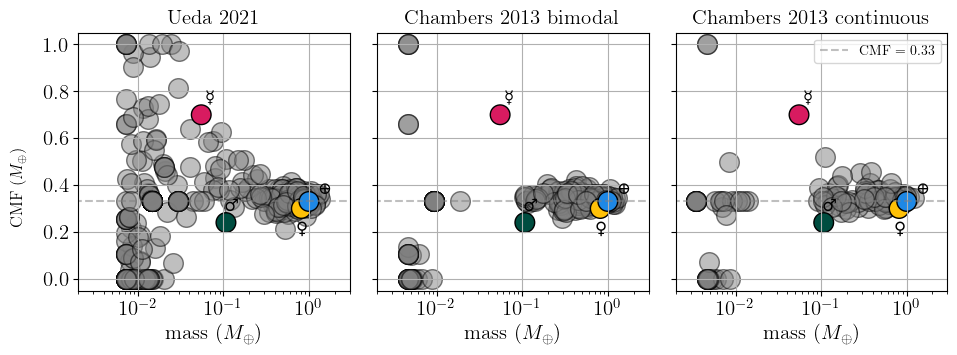

time = 3.00e+08 yrs


In [14]:
fig, axes = plt.subplots(1,3, figsize=(10, 4), sharey=True, sharex=True)
point_size = 200

for ax, (label, df, color) in zip(axes.flat, datasets):
    ax.scatter(df['mass'] * sol_to_earth, df['cmf'], alpha=0.5, edgecolors='black', color = 'grey',
               linewidths=1, s = point_size)

    # Add solar system planets
    ax.scatter(solar_system_df['m'], solar_system_df['CMF'], color = solar_system_df['color'], edgecolors='black', linewidths=1, s = point_size)
    ax.annotate('☿', [0.06, 0.75], fontsize=12, usetex=False)
    ax.annotate('♀', [0.7, 0.19], fontsize=12, usetex=False)
    ax.annotate('⊕', [1.25, 0.36], fontsize=12, usetex=False)
    ax.annotate('♂', [0.1, 0.29], fontsize=12, usetex=False)

    ax.plot([0.001, 10], [0.33, 0.33], linestyle='dashed', color='grey', alpha=0.5, label = 'CMF = 0.33')

    ax.set_xscale('log')
    ax.set_xlabel(r'mass ($M_\oplus$)')

    ax.set_xlim(2 * 1e-3, 3)
    ax.grid(True)
    ax.set_title(label)
    

# Shared axis labels
ax.legend()
fig.text(0.04, 0.5, r'CMF ($M_\oplus$)', va='center', rotation='vertical', fontsize=12)

#fig.suptitle('Uniform CMF distributions (0.33)')
plt.tight_layout(rect=[0.05, 0.05, 1, 1])

#plt.savefig("paper_plots/uniform_m_cmf.pdf", dpi=300)  # or .png

plt.show()

print(f"time = {cut_time:.2e} yrs")
#print("mean max time reached for Ueda v1 = ", np.average(maxtimes_ueda_v1)/1e6, "Myrs")
#print("mean max time reached for Cham = ", np.average(maxtimes_cham_bench)/1e6, "Myrs")


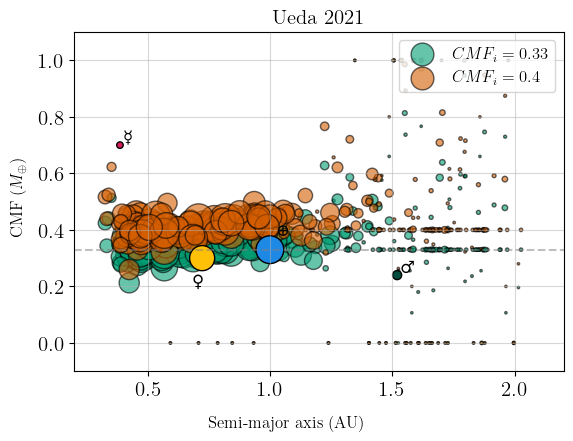

time = 3.00e+08 yrs


In [15]:
# Colorblind-friendly palette (CUD: https://jfly.uni-koeln.de/color/)
color_033 = "#009E73"  # green
color_040 = "#D55E00"  # vermillion

fig, ax = plt.subplots(figsize=(6, 5))

datasets = [
    ("Ueda 2021", ueda_v3_pldf_33, ueda_v3_pldf_40),
]

dot_scale = 400

for label, df_033, df_040 in datasets:
    ax.grid(True, alpha=0.5)
    ax.plot([0.2, 2.2], [0.33, 0.33], linestyle='dashed', color='grey', alpha=0.5)

    # CMF = 0.33 points
    ax.scatter(df_033['semi'], df_033['cmf'], alpha=0.6, color=color_033,
               edgecolors='black', linewidths=1,
               s=df_033['mass'] * sol_to_earth * dot_scale, label=r"$CMF_{i}=0.33$")

    # CMF = 0.4 points
    ax.scatter(df_040['semi'], df_040['cmf'], alpha=0.6, color=color_040,
               edgecolors='black', linewidths=1,
               s=df_040['mass'] * sol_to_earth * dot_scale, label=r"$CMF_{i}=0.4$")

    # Add Solar System planets
    ax.scatter(solar_system_df['a'], solar_system_df['CMF'],
               color=solar_system_df['color'], edgecolors='black', linewidths=1,
               s=solar_system_df['m'] * dot_scale)
    ax.annotate('☿', [0.4, 0.71], fontsize=12, usetex=False)
    ax.annotate('♀', [0.68, 0.2], fontsize=12, usetex=False)
    ax.annotate('⊕', [1.02, 0.38], fontsize=12, usetex=False)
    ax.annotate('♂', [1.53, 0.25], fontsize=12, usetex=False)

    ax.set_xlim(0.2, 2.2)
    ax.set_ylim(-0.1, 1.1)
    ax.set_title(label)

# Shared axis labels
fig.text(0.5, 0.04, 'Semi-major axis (AU)', ha='center', fontsize=12)
fig.text(0.04, 0.5, r'CMF ($M_\oplus$)', va='center', rotation='vertical', fontsize=12)

# Legend
ax.legend(loc='upper right', fontsize=12, frameon=True)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.92])
plt.savefig("paper_plots/higher_metal_ueda_2021.pdf", dpi=300)
plt.show()

print(f"time = {cut_time:.2e} yrs")


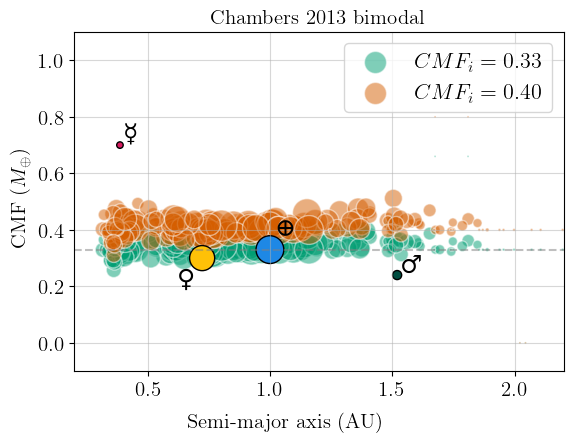

time = 3.00e+08 yrs


In [20]:
# Colorblind-friendly palette (CUD: https://jfly.uni-koeln.de/color/)
color_033 = "#009E73"  # green
color_040 = "#D55E00"  # vermillion

fig, ax = plt.subplots(figsize=(6, 5))

datasets = [
    ("Chambers 2013 bimodal", cham_bench_pldf_33, cham_bench_pldf_40),
]

dot_scale = 400

for label, df_033, df_040 in datasets:
    ax.grid(True, alpha=0.5)
    ax.plot([0.2, 2.2], [0.33, 0.33], linestyle='dashed', color='grey', alpha=0.5)

    # CMF = 0.33 points
    ax.scatter(df_033['semi'], df_033['cmf'], alpha=0.5, color=color_033,
               edgecolors='white', linewidths=1,
               s=df_033['mass'] * sol_to_earth * dot_scale, label=r"$CMF_{i}=0.33$")

    # CMF = 0.4 points
    ax.scatter(df_040['semi'], df_040['cmf'], alpha=0.5, color=color_040,
               edgecolors='white', linewidths=1,
               s=df_040['mass'] * sol_to_earth * dot_scale, label=r"$CMF_{i}=0.40$")

    # Add Solar System planets
    ax.scatter(solar_system_df['a'], solar_system_df['CMF'],
               color=solar_system_df['color'], edgecolors='black', linewidths=1,
               s=solar_system_df['m'] * dot_scale)
    ax.annotate('☿', [0.4, 0.71], fontsize=18, usetex=False)
    ax.annotate('♀', [0.62, 0.2], fontsize=18, usetex=False)
    ax.annotate('⊕', [1.02, 0.38], fontsize=18, usetex=False)
    ax.annotate('♂', [1.53, 0.25], fontsize=18, usetex=False)

    ax.set_xlim(0.2, 2.2)
    ax.set_ylim(-0.1, 1.1)
    ax.set_title(label)

# Shared axis labels
fig.text(0.5, 0.04, 'Semi-major axis (AU)', ha='center')
fig.text(0.04, 0.5, r'CMF ($M_\oplus$)', va='center', rotation='vertical')

# Legend
ax.legend(loc='upper right', fontsize = 16, frameon=True)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.92])
plt.savefig("paper_plots/higher_metal_cham_bimodal_2013.pdf", dpi=300)
plt.show()

print(f"time = {cut_time:.2e} yrs")


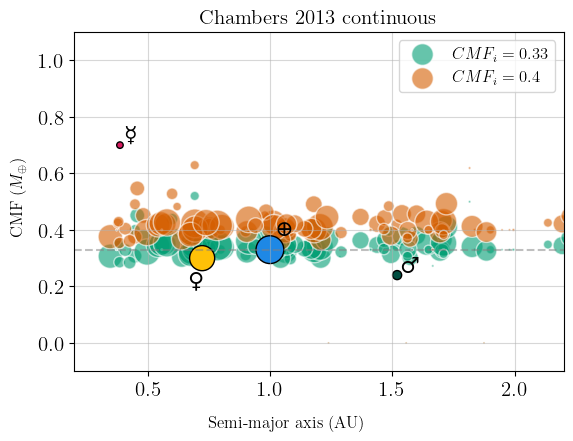

time = 3.00e+08 yrs


In [17]:
# Colorblind-friendly palette (CUD: https://jfly.uni-koeln.de/color/)
color_033 = "#009E73"  # green
color_040 = "#D55E00"  # vermillion

fig, ax = plt.subplots(figsize=(6, 5))

datasets = [
    ("Chambers 2013 continuous", cham_cont_pldf_33, cham_cont_pldf_40)
]

dot_scale = 400

for label, df_033, df_040 in datasets:
    ax.grid(True, alpha=0.5)
    ax.plot([0.2, 2.2], [0.33, 0.33], linestyle='dashed', color='grey', alpha=0.5)

    # CMF = 0.33 points
    ax.scatter(df_033['semi'], df_033['cmf'], alpha=0.6, color=color_033,
               edgecolors='white', linewidths=1,
               s=df_033['mass'] * sol_to_earth * dot_scale, label=r"$CMF_{i}=0.33$")

    # CMF = 0.4 points
    ax.scatter(df_040['semi'], df_040['cmf'], alpha=0.6, color=color_040,
               edgecolors='white', linewidths=1,
               s=df_040['mass'] * sol_to_earth * dot_scale, label=r"$CMF_i=0.4$")

    # Add Solar System planets
    ax.scatter(solar_system_df['a'], solar_system_df['CMF'],
               color=solar_system_df['color'], edgecolors='black', linewidths=1,
               s=solar_system_df['m'] * dot_scale)
    ax.annotate('☿', [0.4, 0.71], fontsize=16, usetex=False)
    ax.annotate('♀', [0.66, 0.2], fontsize=16, usetex=False)
    ax.annotate('⊕', [1.02, 0.38], fontsize=16, usetex=False)
    ax.annotate('♂', [1.53, 0.25], fontsize=16, usetex=False)

    ax.set_xlim(0.2, 2.2)
    ax.set_ylim(-0.1, 1.1)
    ax.set_title(label)

# Shared axis labels
fig.text(0.5, 0.04, 'Semi-major axis (AU)', ha='center', fontsize=12)
fig.text(0.04, 0.5, r'CMF ($M_\oplus$)', va='center', rotation='vertical', fontsize=12)

# Legend
ax.legend(loc='upper right', fontsize=12, frameon=True)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.92])
plt.savefig("paper_plots/higher_metal_cham_cont_2013.pdf", dpi=300)
plt.show()

print(f"time = {cut_time:.2e} yrs")
